# **Perbandingan Ekstraksi Fitur Sobel dan HOG dalam Klasifikasi Gambar Sampah Organik dan Anorganik Menggunakan SVM**

## **Import Libraries**

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from google.colab import drive
import zipfile
from tqdm import tqdm

## **Load dan Eksplorasi Dataset**

### **Load dataset dari folder Train dan Test**

In [2]:
# Install gdown
!pip install -q gdown

# Download Dataset Sampah.zip dari Google Drive
!gdown --id 1pY2T5lVARrq95pj8wf7mGUsscNJhQJPI -O dataset_sampah.zip

# Ekstrak zip ke folder dataset_sampah/
with zipfile.ZipFile("dataset_sampah.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset_sampah")

print("Selesai diunduh dan diekstrak.")

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pY2T5lVARrq95pj8wf7mGUsscNJhQJPI
From (redirected): https://drive.google.com/uc?id=1pY2T5lVARrq95pj8wf7mGUsscNJhQJPI&confirm=t&uuid=27444428-21fe-471a-9211-3699a7434f5d
To: /content/dataset_sampah.zip
100% 3.11G/3.11G [00:39<00:00, 77.8MB/s]
Selesai diunduh dan diekstrak.


In [3]:
base_dir = "dataset_sampah/Dataset Sampah"
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

print("Kelas di Train:", os.listdir(train_dir))
# print("Isi folder Test:", os.listdir(test_dir))

Kelas di Train: ['Organik', 'Anorganik']


### **Visualisasi sampel gambar dari setiap kelas**

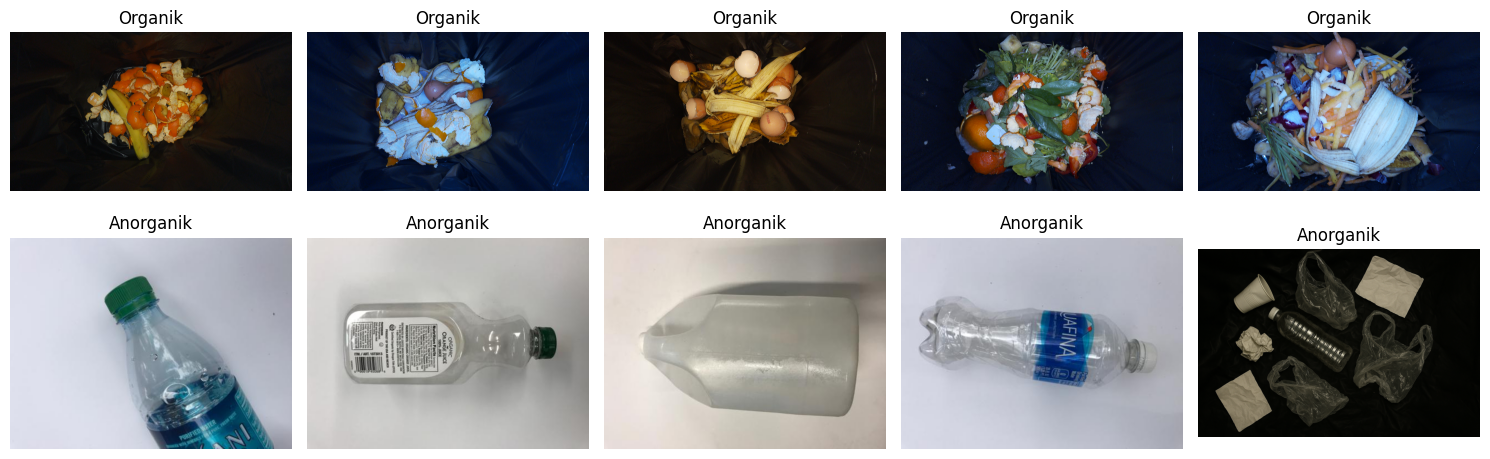

In [4]:
def show_sample_images(data_dir, class_names, num_samples=5):
    plt.figure(figsize=(15, 5))
    for idx, class_name in enumerate(class_names):
        folder_path = os.path.join(data_dir, class_name)
        images = os.listdir(folder_path)
        for i in range(num_samples):
            img_path = os.path.join(folder_path, images[i])
            image = imread(img_path)
            plt.subplot(len(class_names), num_samples, idx * num_samples + i + 1)
            plt.imshow(image)
            plt.axis('off')
            plt.title(class_name)
    plt.tight_layout()
    plt.show()

class_names = os.listdir(train_dir)
show_sample_images(train_dir, class_names)

### **Analisis distribusi dataset**

In [5]:
def class_distribution(data_dir):
    dist = {}
    for class_name in os.listdir(data_dir):
        dist[class_name] = len(os.listdir(os.path.join(data_dir, class_name)))
    return dist

train_dist = class_distribution(train_dir)
print("Distribusi Kelas (Train):", train_dist)

Distribusi Kelas (Train): {'Organik': 200, 'Anorganik': 200}


### **Cek Ukuran dan Format Gambar di Train**

In [6]:
def cek_ukuran_format(data_dir, num_samples=5):
    for class_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, class_name)
        image_files = os.listdir(folder_path)[:num_samples]

        print(f"\nKelas: {class_name}")
        for img_name in image_files:
            img_path = os.path.join(folder_path, img_name)
            try:
                img = imread(img_path)
                print(f"{img_name} - shape: {img.shape}, dtype: {img.dtype}")
            except Exception as e:
                print(f"{img_name} - error: {e}")

cek_ukuran_format(train_dir)


Kelas: Organik
2024-01-09_08%3A44%3A46.730997.png - shape: (2592, 4608, 3), dtype: uint8
2024-01-22_18%3A12%3A05.944006.png - shape: (2592, 4608, 3), dtype: uint8
2024-04-23_13%3A35%3A33.102301.png - shape: (2592, 4608, 3), dtype: uint8
2024-01-27_19%3A33%3A58.835074.png - shape: (2592, 4608, 3), dtype: uint8
2024-03-27_14%3A07%3A01.421113.png - shape: (2592, 4608, 3), dtype: uint8

Kelas: Anorganik
plastic387.jpg - shape: (384, 512, 3), dtype: uint8
plastic208.jpg - shape: (384, 512, 3), dtype: uint8
plastic26.jpg - shape: (384, 512, 3), dtype: uint8
plastic374.jpg - shape: (384, 512, 3), dtype: uint8
Image Jul 3, 2025, 11_14_10 AM (2).png - shape: (1024, 1536, 3), dtype: uint8


## **Preprocessing Gambar**

### **Resize Image**

In [7]:
IMG_SIZE = (128, 128)

def resize_image(image, size=IMG_SIZE):
    return resize(image, size, anti_aliasing=True)

In [8]:
X_resize = []
y_resize = []

label_map = {'Anorganik': 0, 'Organik': 1}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for fname in tqdm(os.listdir(class_path), desc=f"Resizing {class_name}"):
        img_path = os.path.join(class_path, fname)
        try:
            img = imread(img_path)
            img_resized = resize_image(img)
            X_resize.append(img_resized)
            y_resize.append(label_map[class_name])
        except Exception as e:
            print(f"Error processing {img_path}: {e}")


Resizing Anorganik: 100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


In [9]:
X_resize = np.array(X_resize)
y_resize = np.array(y_resize)

print("Shape X_resize:", X_resize.shape)
print("Shape y_resize:", y_resize.shape)

Shape X_resize: (400, 128, 128, 3)
Shape y_resize: (400,)


In [10]:
np.save("X_resize.npy", X_resize)
np.save("y_resize.npy", y_resize)

In [18]:
# from google.colab import files

# files.download("X_resize.npy")
# files.download("y_resize.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

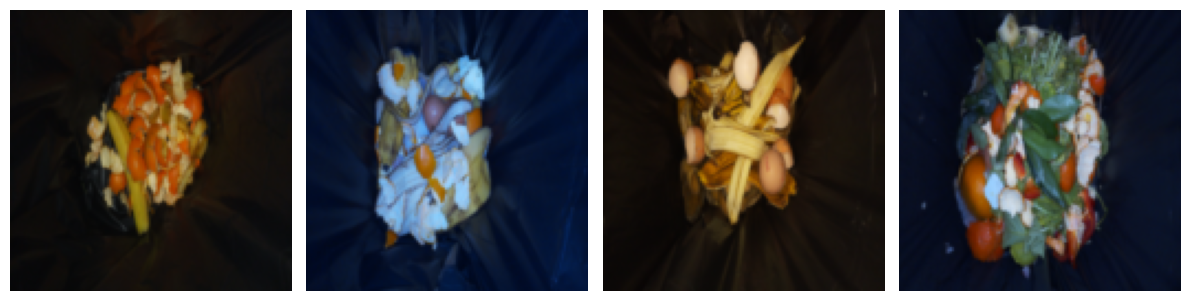

In [17]:
plt.figure(figsize=(12,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_resize[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### **Grayscale**

In [19]:
def to_grayscale(image):
    return rgb2gray(image)

In [20]:
X_gray = []

for img in tqdm(X_resize, desc="Converting to Grayscale"):
    gray = to_grayscale(img)
    X_gray.append(gray)

X_gray = np.array(X_gray)
print("Shape X_gray:", X_gray.shape)

Converting to Grayscale: 100%|██████████| 400/400 [00:00<00:00, 12846.36it/s]

Shape X_gray: (400, 128, 128)


In [21]:
np.save("X_gray.npy", X_gray)
print("Disimpan sebagai X_gray.npy ✅")

Disimpan sebagai X_gray.npy ✅


In [22]:
# from google.colab import files

# files.download("X_gray.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

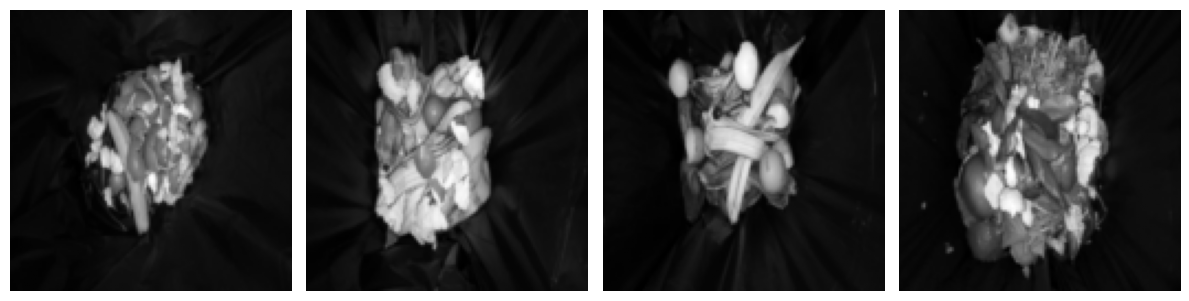

In [24]:
plt.figure(figsize=(12,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_gray[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

### **Normalisasi nilai pixel**

In [25]:
def normalize_image(image):
    return image.astype('float32')  # amanin dtype

In [26]:
X_norm = []

for img in tqdm(X_gray, desc="Normalizing pixels"):
    norm = normalize_image(img)
    X_norm.append(norm)

X_norm = np.array(X_norm)
print("Shape X_norm:", X_norm.shape)
print("Tipe data:", X_norm.dtype)
print("Range nilai pixel: min =", X_norm.min(), ", max =", X_norm.max())

Normalizing pixels: 100%|██████████| 400/400 [00:00<00:00, 35721.29it/s]

Shape X_norm: (400, 128, 128)
Tipe data: float32
Range nilai pixel: min = 0.00021195854 , max = 1.0


In [27]:
np.save("X_norm.npy", X_norm)
print("Disimpan sebagai X_norm.npy ✅")

Disimpan sebagai X_norm.npy ✅


In [28]:
# from google.colab import files

# files.download("X_norm.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

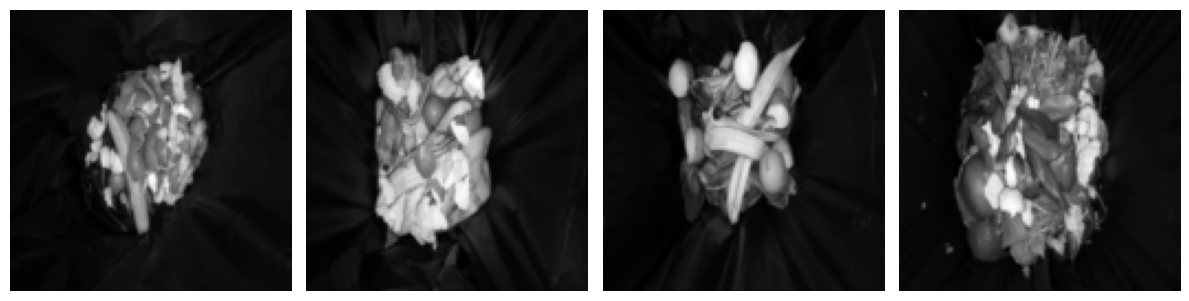

In [30]:
plt.figure(figsize=(12,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_norm[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

## **Feature Extraction**

### **Sobel Edge Detection**

In [31]:
from skimage.filters import sobel_h, sobel_v, sobel

In [32]:
def extract_sobel_features(image):
    # Sobel edge
    edge_h = sobel_h(image)
    edge_v = sobel_v(image)
    edge_mag = sobel(image)  # magnitude gabungan

    # Feature 1: Edge Density (berapa persen edge signifikan)
    threshold = 0.1  # batas threshold untuk "ada edge"
    edge_density = np.sum(edge_mag > threshold) / edge_mag.size

    # Feature 2: Mean & Std Magnitude
    mean_mag = np.mean(edge_mag)
    std_mag = np.std(edge_mag)

    # Gabungkan fitur ke dalam vektor
    return [edge_density, mean_mag, std_mag]

In [33]:
sobel_features = []

for img in tqdm(X_norm, desc="Extracting Sobel features"):
    feats = extract_sobel_features(img)
    sobel_features.append(feats)

X_sobel = np.array(sobel_features)
print("Shape fitur Sobel:", X_sobel.shape)

Extracting Sobel features: 100%|██████████| 400/400 [00:00<00:00, 477.54it/s]

Shape fitur Sobel: (400, 3)


In [34]:
np.save("X_sobel.npy", X_sobel)
print("Fitur Sobel disimpan sebagai X_sobel.npy ✅")

Fitur Sobel disimpan sebagai X_sobel.npy ✅


In [35]:
# from google.colab import files

# files.download("X_sobel.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

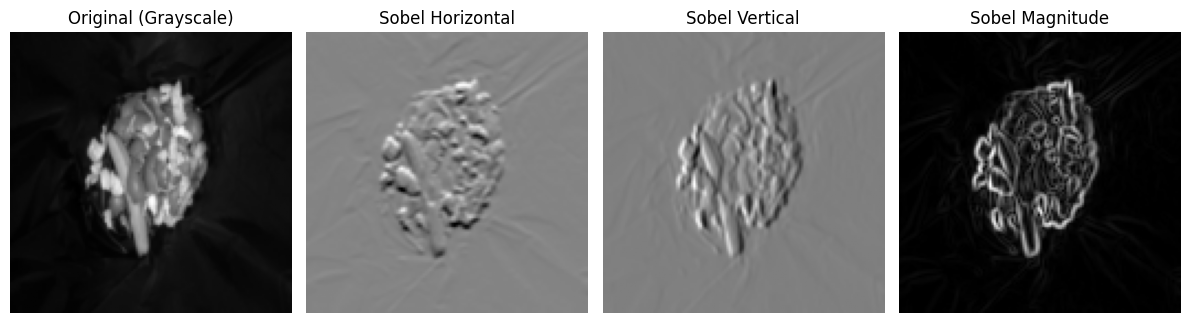

In [36]:
# Ambil satu contoh gambar dari X_norm
example = X_norm[0]  # kamu bisa coba index lain

# Hitung edge Sobel
edge_h = sobel_h(example)
edge_v = sobel_v(example)
edge_mag = sobel(example)

# Tampilkan hasilnya
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(example, cmap='gray')
plt.title("Original (Grayscale)")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(edge_h, cmap='gray')
plt.title("Sobel Horizontal")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(edge_v, cmap='gray')
plt.title("Sobel Vertical")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(edge_mag, cmap='gray')
plt.title("Sobel Magnitude")
plt.axis("off")

plt.tight_layout()
plt.show()

### **HOG**

In [38]:
from skimage.feature import hog

def extract_hog_features(image):
    features, _ = hog(image,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      visualize=True)
    return features

In [39]:
hog_features = []

for img in tqdm(X_norm, desc="Extracting HOG features"):
    feats = extract_hog_features(img)
    hog_features.append(feats)

X_hog = np.array(hog_features)
print("Shape fitur HOG:", X_hog.shape)

Extracting HOG features: 100%|██████████| 400/400 [00:20<00:00, 19.95it/s]

Shape fitur HOG: (400, 8100)


In [40]:
np.save("X_hog.npy", X_hog)

In [59]:
# from google.colab import files

# files.download("X_hog.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
img_gray = X_norm[0]

In [62]:
features, hog_image = hog(img_gray,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=True)

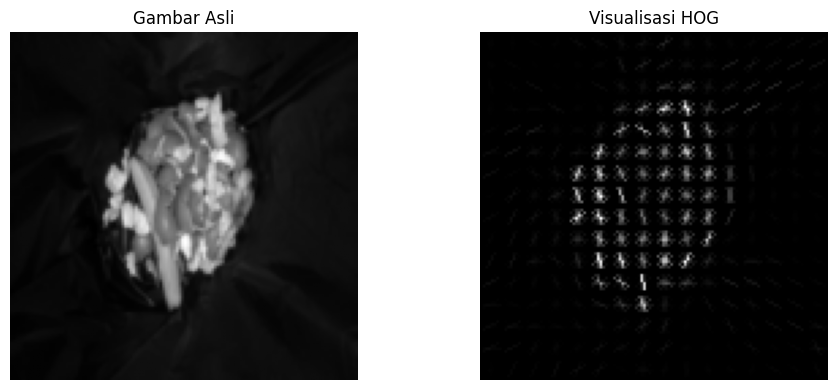

In [63]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title("Gambar Asli")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("Visualisasi HOG")
plt.axis("off")

plt.tight_layout()
plt.show()

## **Modeling (SVM)**

### **Sobel + SVM**

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Load data
X = np.load("X_sobel.npy")
y = np.load("y_resize.npy")

# Split data train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training SVM
model = SVC(kernel='rbf', C=1, gamma='scale')
model.fit(X_train, y_train)

# Prediksi
y_pred_sobel = model.predict(X_test)

print("Classification Report - Sobel + SVM")
print(classification_report(y_test, y_pred_sobel, target_names=["Anorganik", "Organik"]))

Classification Report - Sobel + SVM
              precision    recall  f1-score   support

   Anorganik       0.76      0.78      0.77        36
     Organik       0.81      0.80      0.80        44

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



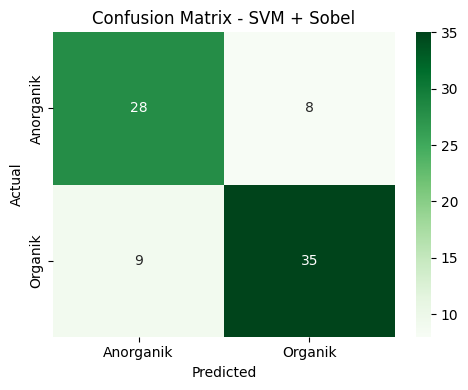

In [48]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_sobel)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Anorganik", "Organik"],
            yticklabels=["Anorganik", "Organik"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM + Sobel")
plt.tight_layout()
plt.show()

### **HOG + SVM**

In [44]:
X = np.load("X_hog.npy")

X_train, X_test, y_train, y_test = train_test_split(X, y_resize, test_size=0.2, random_state=42)

model_hog = SVC(kernel='rbf', C=1, gamma='scale')
model_hog.fit(X_train, y_train)

y_pred_hog = model_hog.predict(X_test)

from sklearn.metrics import accuracy_score
acc_hog = accuracy_score(y_test, y_pred_hog)

# Classification report
print("Classification Report - HOG + SVM")
print(classification_report(y_test, y_pred_hog, target_names=["Anorganik", "Organik"]))

Classification Report - HOG + SVM
              precision    recall  f1-score   support

   Anorganik       0.97      1.00      0.99        36
     Organik       1.00      0.98      0.99        44

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



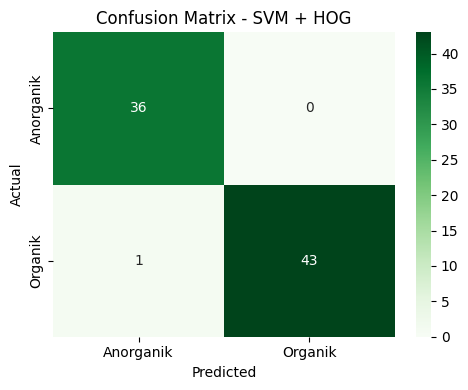

In [47]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_hog)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Anorganik", "Organik"],
            yticklabels=["Anorganik", "Organik"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM + HOG")
plt.tight_layout()
plt.show()

## **Evaluasi**

In [49]:
# Load model dan parameter
IMG_SIZE = (128, 128)
model = model_hog

In [50]:
def preprocess_for_hog(img):
    img_resized = resize(img, IMG_SIZE, anti_aliasing=True)
    img_gray = rgb2gray(img_resized)
    return img_gray

def extract_hog_features(image):
    features, _ = hog(image,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      visualize=True)
    return features

In [52]:
test_dir = "/content/dataset_sampah/Dataset Sampah/Test"

test_images = []
test_filenames = []

for fname in tqdm(os.listdir(test_dir), desc="Predicting Test Images"):
    try:
        img_path = os.path.join(test_dir, fname)
        img = imread(img_path)
        img_gray = preprocess_for_hog(img)
        feats = extract_hog_features(img_gray)
        test_images.append(feats)
        test_filenames.append(fname)
    except Exception as e:
        print(f"Gagal proses {fname}: {e}")

X_test_custom = np.array(test_images)

# Prediksi
y_pred_custom = model.predict(X_test_custom)

Predicting Test Images: 100%|██████████| 101/101 [04:56<00:00,  2.93s/it]


In [53]:
label_map = {0: "Anorganik", 1: "Organik"}

for fname, pred in zip(test_filenames, y_pred_custom):
    print(f"{fname} => Predicted: {label_map[pred]}")

plastic860.jpg => Predicted: Anorganik
plastic857.jpg => Predicted: Anorganik
2024-01-09_11%3A44%3A10.429343.png => Predicted: Organik
2024-01-10_16%3A46%3A32.219982.png => Predicted: Organik
plastic44.jpg => Predicted: Anorganik
plastic186.jpg => Predicted: Anorganik
2024-01-10_20%3A50%3A30.295426.png => Predicted: Organik
2024-04-26_18%3A29%3A16.850844.png => Predicted: Organik
plastic170.jpg => Predicted: Anorganik
plastic157.jpg => Predicted: Anorganik
plastic162.jpg => Predicted: Anorganik
2024-01-10_17%3A15%3A54.447739.png => Predicted: Organik
plastic42.jpg => Predicted: Anorganik
plastic173.jpg => Predicted: Anorganik
2024-04-27_13%3A14%3A41.003684.png => Predicted: Organik
plastic865.jpg => Predicted: Anorganik
2024-01-09_16%3A55%3A05.100360.png => Predicted: Organik
2024-01-10_12%3A29%3A01.031348.png => Predicted: Organik
2024-01-10_21%3A28%3A17.212236.png => Predicted: Organik
2024-01-15_13%3A40%3A51.250624.png => Predicted: Organik
2024-01-16_18%3A15%3A15.339531.png => Pred

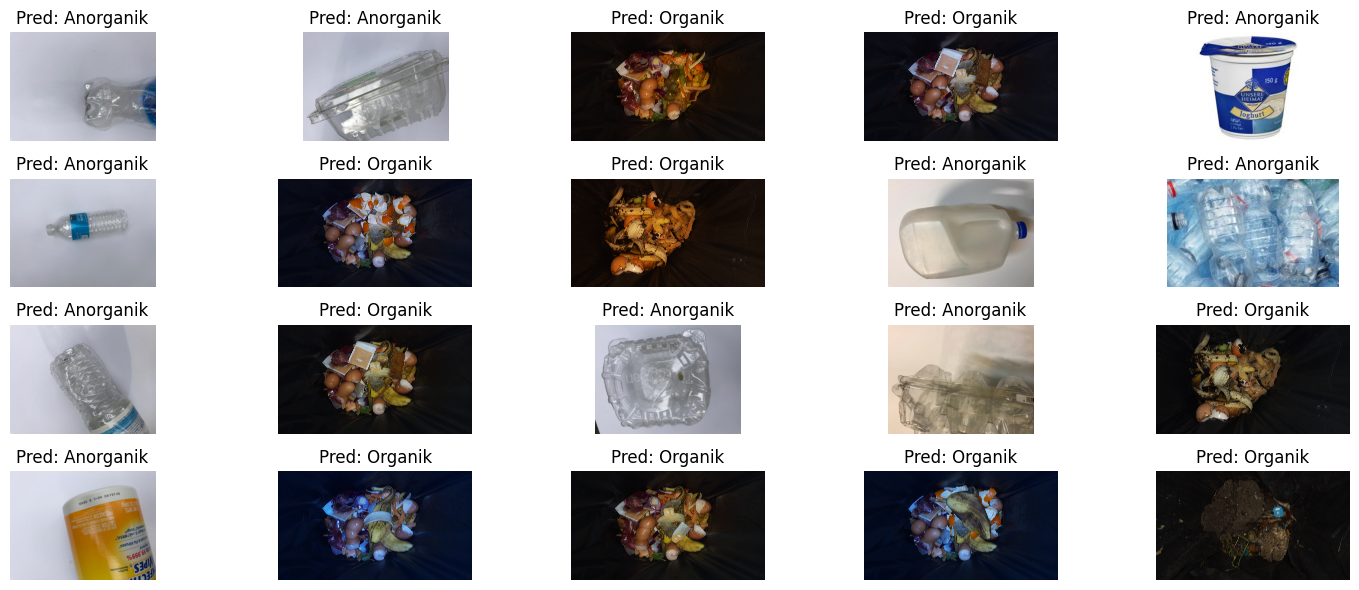

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
for i in range(20):
    img_path = os.path.join(test_dir, test_filenames[i])
    img = imread(img_path)
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {label_map[y_pred_custom[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [56]:
# import joblib

# # Simpan model
# joblib.dump(model_hog, "svm_hog_model.pkl")

# print("✅ Model berhasil disimpan sebagai 'svm_hog_model.pkl'")

✅ Model berhasil disimpan sebagai 'svm_hog_model.pkl'


In [57]:
# from google.colab import files
# files.download("svm_hog_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>